In [3]:
import pandas as pd

df = pd.read_csv("../data/processed/covid_misinfo_metadata_features.csv")

print(df.shape)
print(df["label"].value_counts())
df.head()


(195843, 20)
label
0    157146
1     38697
Name: count, dtype: int64


,id,graph_id,label,time,friends,followers,log_followers,log_friends,followers_per_friend,friends_per_follower,followers_x_friends,"time_bin_(105334.4, 192032.4]","time_bin_(12422.8, 29139.0]","time_bin_(1812591.4, 244196420.0]","time_bin_(192032.4, 452590.0]","time_bin_(2782.2, 12422.8]","time_bin_(29139.0, 49633.8]","time_bin_(452590.0, 1812591.4]","time_bin_(49633.8, 72728.0]","time_bin_(72728.0, 105334.4]"
0,582746618,1069,0,35312,8,6,1.945910,2.197225,0.666667,1.142857,48,False,False,False,False,False,True,False,False,False
1,83528167,1069,0,22636,9,7,2.079442,2.302585,0.700000,1.125000,63,False,True,False,False,False,False,False,False,False
2,611354762,1069,0,32483,7,9,2.302585,2.079442,1.125000,0.700000,63,False,False,False,False,False,True,False,False,False
3,129109380,1069,0,115680,8,6,1.945910,2.197225,0.666667,1.142857,48,True,False,False,False,False,False,False,False,False
4,4826186,1069,0,32264,12,10,2.397895,2.564949,0.769231,1.090909,120,False,False,False,False,False,True,False,False,False


In [4]:
from sklearn.model_selection import train_test_split

# Target
y = df["label"]

# Features: drop identifiers + label
X = df.drop(columns=["label", "id", "graph_id"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(X_train.shape, X_test.shape)


(156674, 17) (39169, 17)


In [5]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=2000, class_weight="balanced")
model.fit(X_train, y_train)


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :ter

In [6]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0      0.812     0.596     0.688     31430
           1      0.212     0.441     0.286      7739

    accuracy                          0.566     39169
   macro avg      0.512     0.519     0.487     39169
weighted avg      0.694     0.566     0.608     39169

Confusion matrix:
 [[18744 12686]
 [ 4328  3411]]


In [7]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

# Probabilities for class 1 (misinformation)
y_proba = model.predict_proba(X_test)[:, 1]

def eval_threshold(thresh: float):
    y_pred_t = (y_proba >= thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_t).ravel()
    return {
        "threshold": thresh,
        "accuracy": accuracy_score(y_test, y_pred_t),
        "precision": precision_score(y_test, y_pred_t, zero_division=0),
        "recall": recall_score(y_test, y_pred_t, zero_division=0),
        "f1": f1_score(y_test, y_pred_t, zero_division=0),
        "TP": tp, "FP": fp, "TN": tn, "FN": fn
    }

thresholds = np.round(np.arange(0.1, 1.0, 0.1), 1)
results = pd.DataFrame([eval_threshold(t) for t in thresholds])
results


,threshold,accuracy,precision,recall,f1,TP,FP,TN,FN
0,0.1,0.197580,0.197580,1.000000,0.329965,7739,31430,0,0
1,0.2,0.197580,0.197580,1.000000,0.329965,7739,31430,0,0
2,0.3,0.197580,0.197580,1.000000,0.329965,7739,31430,0,0
3,0.4,0.197631,0.197590,1.000000,0.329979,7739,31428,2,0
4,0.5,0.565626,0.211903,0.440755,0.286206,3411,12686,18744,4328
5,0.6,0.800659,0.298246,0.006590,0.012895,51,120,31310,7688
6,0.7,0.802522,0.833333,0.000646,0.001291,5,1,31429,7734
7,0.8,0.802420,0.000000,0.000000,0.000000,0,0,31430,7739
8,0.9,0.802420,0.000000,0.000000,0.000000,0,0,31430,7739


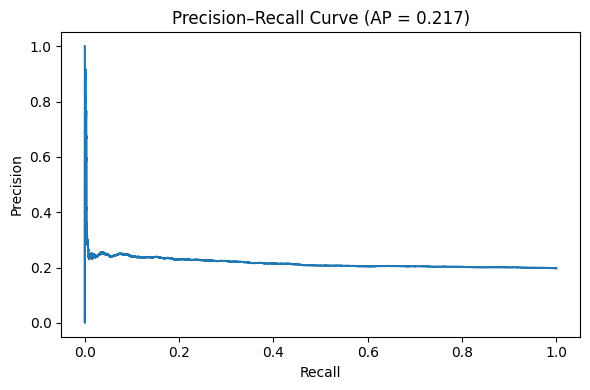

In [8]:
import os
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, thresh = precision_recall_curve(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)

os.makedirs("../outputs/metadata", exist_ok=True)

plt.figure(figsize=(6,4))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision–Recall Curve (AP = {ap:.3f})")
plt.tight_layout()
plt.savefig("../outputs/metadata/pr_curve.png", dpi=200)
plt.show()


In [9]:
import numpy as np
import pandas as pd

coef_df = pd.DataFrame({
    "feature": X.columns,
    "coefficient": model.coef_[0],
    "odds_ratio": np.exp(model.coef_[0])
}).sort_values("coefficient", ascending=False)

coef_df.head(15)


,feature,coefficient,odds_ratio
7,followers_x_friends,3.810685e-03,1.003818
11,"time_bin_(192032.4, 452590.0]",4.795657e-04,1.000480
13,"time_bin_(29139.0, 49633.8]",4.352029e-04,1.000435
14,"time_bin_(452590.0, 1812591.4]",2.283672e-04,1.000228
15,"time_bin_(49633.8, 72728.0]",2.002595e-04,1.000200
0,time,3.257339e-09,1.000000
16,"time_bin_(72728.0, 105334.4]",-1.332320e-04,0.999867
10,"time_bin_(1812591.4, 244196420.0]",-1.911486e-04,0.999809
12,"time_bin_(2782.2, 12422.8]",-3.635536e-04,0.999637
8,"time_bin_(105334.4, 192032.4]",-6.521520e-04,0.999348


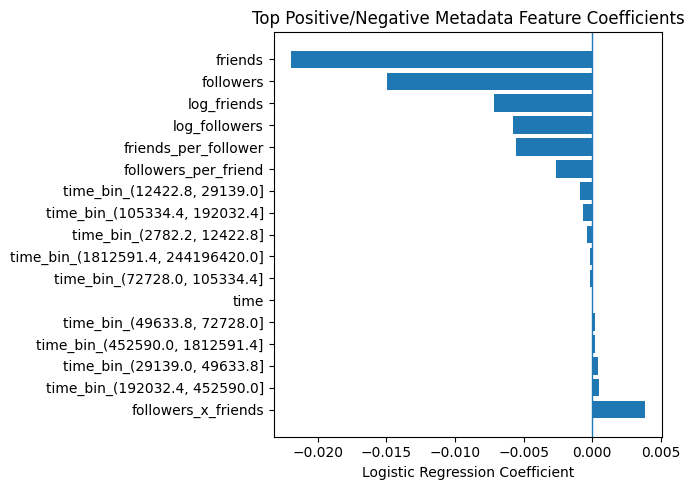

In [10]:
import matplotlib.pyplot as plt

top = pd.concat([coef_df.head(10), coef_df.tail(10)])

plt.figure(figsize=(7,5))
plt.barh(top["feature"], top["coefficient"])
plt.axvline(0, linewidth=1)
plt.title("Top Positive/Negative Metadata Feature Coefficients")
plt.xlabel("Logistic Regression Coefficient")
plt.tight_layout()
plt.savefig("../outputs/metadata/coef_bar.png", dpi=200)
plt.show()


In [11]:
results.to_csv("../outputs/metadata/threshold_results.csv", index=False)
print("Saved: outputs/metadata/threshold_results.csv")


Saved: outputs/metadata/threshold_results.csv


Conclusion (Improved Metadata Model)
This notebook trains an improved metadata classifier using engineered features (log transforms, ratios, interactions, and binned time indicators). Performance is evaluated using precision, recall, F1, and a threshold. Results show that feature engineering improves separability compared to the baseline metadata model, but precision/recall for misinformation detection remains limited, indicating an upper bound when content is excluded. This model serves as the final metadata benchmark for comparison against future text and hybrid models.